In [1]:
import json
from matplotlib import pyplot as plt
import matplotlib.font_manager as font_manager
import numpy as np

json_file = "../../experiments/exp002_20240907_sna_kadirburak/data-tshark/data.json"
with open(json_file) as f:
    data = json.load(f)

# filter data by unique source addresses and get lists

In [2]:
lo_uniqueSAs = []
lo_freqs     = []
lo_SActrs    = []
lo_SSIDs     = []
for pkt in data:
    if(pkt["_source"]["layers"]["wlan.sa"] not in lo_uniqueSAs):
        lo_uniqueSAs.append(pkt["_source"]["layers"]["wlan.sa"])
        lo_freqs.append(pkt["_source"]["layers"]["wlan_radio.frequency"][0])
        lo_SActrs.append(1)
        lo_SSIDs.append(pkt["_source"]["layers"]["wlan.ssid"][0])
    else:
        position_of_uniqueSA_in_listofuniqueSAs = lo_uniqueSAs.index(pkt["_source"]["layers"]["wlan.sa"])
        lo_SActrs[position_of_uniqueSA_in_listofuniqueSAs] += 1

### per-SSID statistics

In [3]:
print("SSID | Source Address    |  Freq |  # of occurrences")
print("-"*50)
KU_AP_idx = []
for i, ssid in enumerate(lo_SSIDs):
    if ssid == "KU":
        print(ssid, "  |", lo_uniqueSAs[i][0], "| ", lo_freqs[i], "| ", lo_SActrs[i])
        KU_AP_idx.append(i)

SSID | Source Address    |  Freq |  # of occurrences
--------------------------------------------------
KU   | 4c:77:6d:92:b3:60 |  2437 |  860
KU   | 4c:77:6d:5f:ea:e0 |  2437 |  862
KU   | 4c:77:6d:05:af:20 |  2462 |  849
KU   | 4c:77:6d:a0:45:c0 |  2462 |  861
KU   | 4c:77:6d:5f:e1:e0 |  2462 |  460
KU   | 4c:77:6d:05:a4:00 |  2412 |  832
KU   | 4c:77:6d:96:5b:20 |  2412 |  837
KU   | 4c:77:6d:a0:44:60 |  2412 |  565
KU   | 4c:77:6d:5f:da:c0 |  2412 |  773
KU   | 4c:77:6d:9d:e7:e0 |  2412 |  145
KU   | b4:de:31:f5:7e:00 |  2412 |  269
KU   | 4c:77:6d:93:1d:21 |  2412 |  258
KU   | 4c:77:6d:9d:ea:e0 |  2437 |  233
KU   | 20:a5:cb:c8:d5:5d |  2437 |  6
KU   | 0e:8a:ef:72:fc:b5 |  2437 |  11
KU   | 4c:77:6d:96:88:60 |  2412 |  6
KU   | 00:fc:ba:7e:0d:e0 |  2437 |  1


In [4]:
KU_AP_idx

[1, 4, 9, 11, 14, 15, 17, 21, 22, 29, 32, 33, 36, 43, 44, 45, 52]

# plotting SSID occurrences

prototype

In [5]:
data[1]

{'_index': 'packets-2024-09-07',
 '_type': 'doc',
 '_score': None,
 '_source': {'layers': {'frame.time': ['18:03:23.25'],
   'wlan_radio.signal_dbm': ['-64'],
   'wlan.sa': ['4c:77:6d:92:b3:60'],
   'wlan.ra': ['ff:ff:ff:ff:ff:ff'],
   'wlan.da': ['ff:ff:ff:ff:ff:ff'],
   'wlan_radio.frequency': ['2437'],
   'wlan.ssid': ['KU'],
   'loc_x': ['1.1371889'],
   'loc_y': ['2.3746476']}}}

In [6]:
def frametime2secs(frametime):
    hrs   = int(frametime.split(":")[0])
    mins  = int(frametime.split(":")[1])
    secs  = int((frametime.split(":")[2]).split(".")[0])
    msecs = int((frametime.split(":")[2]).split(".")[1])
    total_seconds = (hrs*60*60*1000 + mins*60*1000 + secs*1000 + msecs) / 1000.0 
    return total_seconds

def get_timeinsecs(sampledict, offset=0):
    return frametime2secs(sampledict["_source"]["layers"]["frame.time"][0]) - offset;

def get_freq(sampledict):
    return sampledict["_source"]["layers"]["wlan_radio.frequency"][0]

def get_sourceaddr(sampledict):
    return sampledict["_source"]["layers"]["wlan.sa"]
    
def get_ssid(sampledict):
    return sampledict["_source"]["layers"]["wlan.ssid"][0]
    
def get_rss(sampledict):
    return sampledict["_source"]["layers"]["wlan_radio.signal_dbm"][0]

test fcns

In [7]:
print(get_timeinsecs(data[1], offset=65003.025))
print(get_freq(data[1]))
print(get_sourceaddr(data[1])[0])
print(get_ssid(data[1]))
print(get_rss(data[1]))

0.0
2437
4c:77:6d:92:b3:60
KU
-64


get the time axis

In [8]:
time = []
for sample in data:
    t = get_timeinsecs(sample, offset=65003.025)
    if(t not in time):
        time.append(t)

### record KU RSS values

first throw out the ones with <300 occurrences (last 8 records in the list)

In [9]:
KU_AP_idx_filtered = KU_AP_idx[:-8]

In [10]:
lo_uniqueSAs[KU_AP_idx_filtered[-1]]

['4c:77:6d:5f:da:c0']

In [11]:
array_ssid_rss = np.zeros((len(time), len(KU_AP_idx_filtered)))*np.nan
for sample in data:
    t_sample  = get_timeinsecs(sample, offset=65003.025)
    t_idx     = time.index(t_sample)
    sa_sample = get_sourceaddr(sample)
    sa_idx    = lo_uniqueSAs.index(sa_sample)
    if(sa_idx in KU_AP_idx_filtered):
        array_ssid_idx = KU_AP_idx_filtered.index(sa_idx)
        array_ssid_rss[t_idx, array_ssid_idx] = get_rss(sample)

**First 15 records are informative**

    [-61., -73.,  nan,  nan,  nan,  nan,  nan,  nan,  nan], --> time: 0.0 
    [-63., -70.,  nan,  nan,  nan,  nan,  nan,  nan,  nan], --> time: 0.02500000000145519
    [ nan,  nan, -84., -76., -89.,  nan,  nan,  nan,  nan], --> time: 0.049999999995634425
    [ nan,  nan, -82., -68., -89.,  nan,  nan,  nan,  nan], --> time: 0.9749999999985448
    [ nan,  nan,  nan,  nan,  nan, -82., -84., -84., -88.], --> time: 1.0
    [ nan,  nan,  nan,  nan,  nan, -82., -81., -85., -84.], --> time: 1.0250000000014552
    [-66., -70.,  nan,  nan,  nan,  nan,  nan,  nan,  nan], --> time: 1.0499999999956344
    [-68., -71.,  nan,  nan,  nan,  nan,  nan,  nan,  nan], --> time: 1.9749999999985448
    [ nan, -71., -82., -69.,  nan,  nan,  nan,  nan,  nan], --> time: 2.0
    [ nan,  nan, -82., -69., -89.,  nan,  nan,  nan,  nan], --> time: 2.025000000001455
    [ nan,  nan,  nan,  nan,  nan, -82., -82., -86., -86.], --> time: 2.0499999999956344
    [ nan,  nan,  nan,  nan,  nan, -82., -82., -86., -86.], --> time: 2.974999999998545
    [-67., -73.,  nan,  nan,  nan, -82., -83.,  nan, -86.], --> time: 3.0
    [-67., -72.,  nan,  nan,  nan,  nan,  nan,  nan,  nan], --> time: 3.025000000001455
    [-69., -72., -81., -67., -88.,  nan,  nan,  nan,  nan]  --> time: 3.0499999999956344

those columns that appear together are from different frequencies

**dwell time is evident here, but a =0.5s dwell time resulted in approx. 1 second jumps for us, that's interesting**

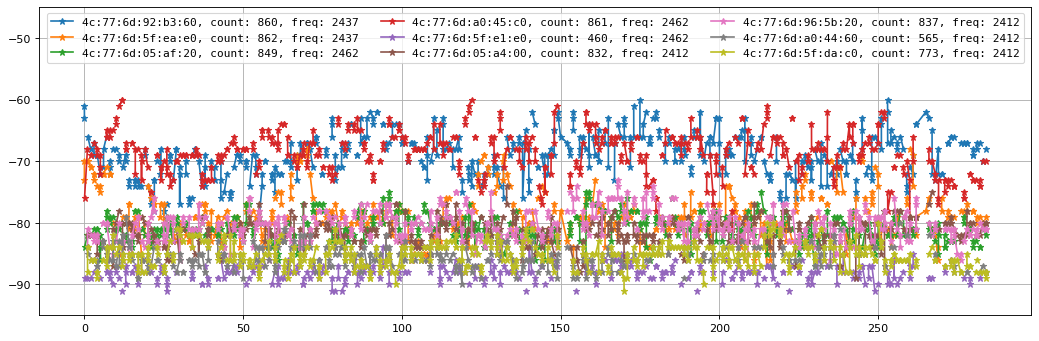

In [12]:
plt.figure(figsize=(16, 5), dpi=80)
plt.plot(time, array_ssid_rss, marker="*");
plt.ylim([-95, -45])
plt.grid()
plt.legend([(lo_uniqueSAs[idx][0]+ ", count: " + str(lo_SActrs[idx]) + ", freq: " + str(lo_freqs[idx])) for idx in KU_AP_idx_filtered], 
           prop=font_manager.FontProperties(family='monospace'), loc='upper center', ncol=3)

**zoom in a bit**

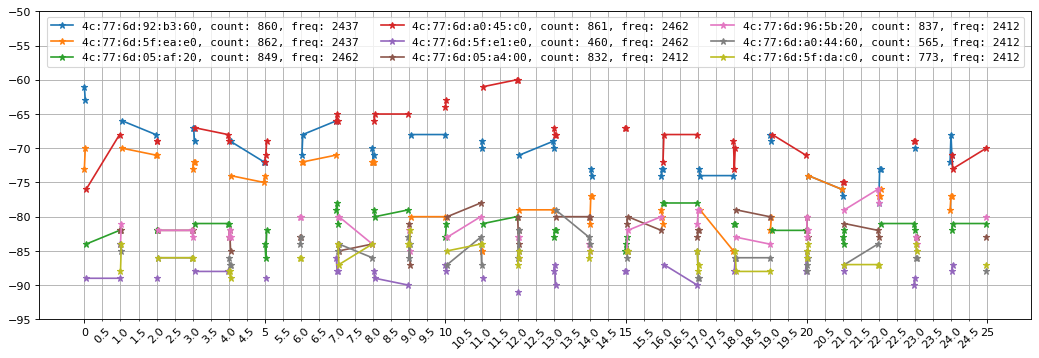

In [13]:
fig = plt.figure(figsize=(16, 5), dpi=80)
ax  = fig.add_subplot(1, 1, 1)
cutout = 100
ax.plot(time[:cutout], array_ssid_rss[:cutout], marker="*");
ax.set_ylim([-95, -50])
ax.set_xticks(np.linspace(0,int(time[cutout]) - 1/2,int(time[cutout])*2), minor=True)
ax.set_xticklabels(np.linspace(0,int(time[cutout]) - 1/2,int(time[cutout])*2), minor=True, rotation=45)
ax.grid(which='both')
ax.legend([(lo_uniqueSAs[idx][0]+ ", count: " + str(lo_SActrs[idx]) + ", freq: " + str(lo_freqs[idx])) for idx in KU_AP_idx_filtered], 
           prop=font_manager.FontProperties(family='monospace'), loc='upper center', ncol=3)